# Coursework Assignment: Building a Regression Model

```
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area

Banks and Credit Institutions are often required to assess the values of properties in their portfolios by policymakers, concerned about their solvency, given that the collateral to the mortgages they trade are essentially properties themselves[[1](#ref:2007:hjort-et-al)]. However, Pension Funds[[2](#ref:2022:rastegar)] or any other company or person investing in real estate can benefit from understanding where the market trends are more likely heading.

The updated property prices must be predicted frequently and are traditionally processed using a system commercially known as an "Automated Valuation Model" (or AVM)[[1](#ref:2007:hjort-et-al), [3](#ref:web:rightmove-avm)]. These are either (a) a hedonic regression model, that regresses the transaction price from the set of features intrinsic to the property (e.g. the number of bedrooms), (b) a model focusing on repeated sales of the same property, to understand the price variations of the same object, (c) a hybrid model using features from both approaches, or (d) models including spatial methods [[1](#ref:2007:hjort-et-al)].

Hedonic regression relies on variables mapped to property prices linearly, and "the linear assumption can be unrealistic"[[1](#ref:2007:hjort-et-al)]. Recently Neural Networks have been suggested as an alternative for House Price Forecasting that resulted in a 1% Average Relative Root Mean Square Error across one hundred cities in China[[4](#ref:2021:xu-et-al)], perhaps suggesting the ability to break the linearity is a relevant component in house price predictions.

The present work presents two hedonic regression models, the first based on Polynomial Regression, and the second based on Multi-layer Perceptron Regression, both regressing property prices from intrinsic features of these properties, trained on the Price Paid Data[[5](#ref:web:uk-land-registry)] provided by the HM Land Registry in the United Kingdom.


## Dataset

To build a property price regressor, data related to property transactions was collected. The UK HM Land Registry department provides a high-quality dataset in CSV format called **Price Paid Data**[[5](#ref:web:uk-land-registry)], containing information such as the date of the transaction, and the type of the property, which looked, at first, relevant data to feed into a hedonic regressor.

Additionally, extra data was collected for information that would intuitively seem to be strongly correlated to variation in property prices, such as the **Interest Rate over Time**[[6](ref:web:uk-boe-interest)] and the **Inflation Rate over Time**[[7](#ref:web:uk-ons-cpih)], both known to be connected to the purchasing power and, therefore, to demand.

> Contains HM Land Registry data © Crown copyright and database right 2021.<br />
> This data is licensed under the Open Government Licence v3.0.

### Real Estate Transaction History

#### Summary

| **Organisation** | HM Land Registry                                                                                                                                                                                                                                                                     |
| ---------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Name**         | Price Paid Data                                                                                                                                                                                                                                                                      |
| **Last Update**  | 31 November 2022                                                                                                                                                                                                                                                                     |
| **Source URL**   | https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads                                                                                                                                                                                                        |
| **License**      | [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)                                                                                                                                                                           |
| **File Format**  | 4 yearly consolidated `.csv` files (2018, 2019, 2020, 2021), each with approximately 120MB & 1 partial yearly `.csv` file (2022) with approximately 5MB. These were stored locally as zip files, which resulted in files under 30MB fit for being uploaded into a Github repository. |
| **Attributes**   | Price, Timestamp, Address, Property Type and other attributes, described in full in the schema section below.                                                                                                                                                                        |
| **Instances**    | 4,336,841 transactions                                                                                                                                                                                                                                                               |
| **Impurities**   | One property category `other` is too broad to provide signal for the regression, and therefore must be ignored. Also, entries with missing `postcodes` are insufficient for our modelling activities, therefore they must also be eliminated.                                        |

#### Schema

| **Column**            | **Dtype** | **Nature**  |
| --------------------- | :-------: | :---------: |
| **id**                |   uuid    |  numerical  |
| **price**             |  integer  |  numerical  |
| **date**              |  string   |    date     |
| **postcode**          |  string   | categorical |
| **property_type**     |  string   | categorical |
| **old_or_new**        |  string   | categorical |
| **duration**          |  object   | categorical |
| **paon**              |  object   |    text     |
| **saon**              |  object   |    text     |
| **street**            |  object   |    text     |
| **locality**          |  object   |    text     |
| **town_city**         |  object   |    text     |
| **district**          |  object   |    text     |
| **county**            |  object   | categorical |
| **ppd_category_type** |  object   | categorical |
| **record_status**     |  object   | categorical |

#### Missing Attribute Values

|              | **missing** |  **%** |
| ------------ | ----------: | -----: |
| **postcode** |      18,471 |   0.4% |
| **saon**     |   4,013,617 | 87.29% |
| **street**   |      86,816 |  1.89% |
| **locality** |   2,846,155 |  61.9% |

#### Unique Attribute Values

|                       | **uniques** |  **%** |
| --------------------- | ----------: | -----: |
| **id**                |   4,597,894 | 100.0% |
| **price**             |      96,000 |  2.09% |
| **date**              |       1,758 |  0.04% |
| **postcode**          |   1,044,446 | 22.72% |
| **property_type**     |           5 |   0.0% |
| **old_or_new**        |           2 |   0.0% |
| **duration**          |           2 |   0.0% |
| **paon**              |     243,571 |   5.3% |
| **saon**              |      30,493 |  0.66% |
| **street**            |     278,907 |  6.07% |
| **locality**          |      20,583 |  0.45% |
| **town_city**         |       1,151 |  0.03% |
| **district**          |         357 |  0.01% |
| **county**            |         115 |   0.0% |
| **ppd_category_type** |           2 |   0.0% |

### Interest Rate over Time

#### Summary

| **Organisation** | Bank of England                                                                                                                        |
| ---------------- | :------------------------------------------------------------------------------------------------------------------------------------- |
| **Name**         | Official Bank Rate history                                                                                                             |
| **Last Update**  | 20 December 2022                                                                                                                       |
| **Source URL**   | https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp                                                                         |
| **License**      | [UK Open Government Licence](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)                                |
| **File Format**  | 1 file in `.csv` format                                                                                                                |
| **Attributes**   | `Date changed` and `rate`                                                                                                              |
| **Instances**    | 582 instances                                                                                                                          |
| **Impurities**   | Only presents the "dates of change", so to know the tax in a given day, the dataset will have to be interpolated to a daily frequency. |

#### Schema

| **Column**       | **DType** | **Nature** |
| ---------------- | :-------: | :--------: |
| **Date changed** |    str    |    date    |
| **rate**         |   float   |   float    |

#### Missing Attribute Values

There are no missing values in this dataset

#### Unique Attribute Values

|          | **uniques** |  **%** |
| -------- | ----------: | -----: |
| **rate** |         114 | 46.15% |

### Inflation Rate over Time

#### Summary

| **Organisation** | Office for National Statistics                                                                                                                                                                                                                                                                                                                                       |
| ---------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Name**         | CPIH ANNUAL RATE 00: ALL ITEMS 2015=100                                                                                                                                                                                                                                                                                                                              |
| **Last Update**  | 20 December 2022                                                                                                                                                                                                                                                                                                                                                     |
| **Source URL**   | https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23                                                                                                                                                                                                                                                                                         |
| **License**      | [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)                                                                                                                                                                                                                                                           |
| **File Format**  | 1 file in `.csv` format                                                                                                                                                                                                                                                                                                                                              |
| **Attributes**   | `Title` containing the "date" and `CPIH ANNUAL RATE 00: ALL ITEMS 2015=100` containing the "rate"                                                                                                                                                                                                                                                                    |
| **Instances**    | 582 rows                                                                                                                                                                                                                                                                                                                                                             |
| **Impurities**   | (1) The file is not in tabular format, and some rows must be ignored; (2) the `Title` column contains the `date` of the rate change, but it is not in any standardised date format, so it must first be translated; (3) The `CPIH ANNUAL RATE 00: ALL ITEMS 2015=100` also contains non-numeric characters and invalid values (e.g.: `-`), which must be cleaned up. |

#### Schema

| **Column**                                  | **DType** | **Nature** |
| ------------------------------------------- | :-------: | :--------: |
| **Title**                                   |    str    |    date    |
| **CPIH ANNUAL RATE 00: ALL ITEMS 2015=100** |   float   |   float    |

#### Missing Attribute Values

|                                             | **missing** | **%** |
| ------------------------------------------- | ----------: | ----: |
| **CPIH ANNUAL RATE 00: ALL ITEMS 2015=100** |           7 |  1.2% |

#### Unique Attribute Values

|                                             | **uniques** |  **%** |
| ------------------------------------------- | ----------: | -----: |
| **date**                                    |         582 | 100.0% |
| **CPIH ANNUAL RATE 00: ALL ITEMS 2015=100** |          76 | 13.06% |


## Objectives

This document **aims** to produce a model that regresses the price for UK properties of type semi-detached, detached, flats and terraced, from variables such as the property type itself, if it is new or old, duration which can be either lease or freehold, as well as the inflation and interest rates.

Successfully achieving this **aim** would provide us with a model that could benefit decision-making based on UK property prices for present transactions, using information presently available at the time of the property purchase or sale, as well as for future transactions, provided that the model is fed with an accurate estimate of what the inflation and interest rate would be at the time of the transaction.

The **objectives** set out to pursue this aim are:

1. Observe the **correlation between continuous variables such as inflation rate, interest rate and price**. Intuition suggests that these variables should demonstrate some correlation, a hypothesis that shall become apparent when using an appropriate Data Visualisation technique. A high correlation between these variables is not required but might help to explain some price variation phenomena.

2. **Resolve the problem of sparsity and high-dimensionality of the dataset**, caused by the one-hot encoding of the postcode information that results in 2000+ sparse features, which asymptotically grows far too large in terms of time-complexity for any higher degree polynomial linear regression model to be trained. This problem shall be approached through _Feature Engineering_ and _Dimensionality Reduction_ and not _Feature Selection_, which could result in information loss, due to the sparsity of the features.

3. **Compare the MAPE metric between several different Polynomial Hedonic Regression and Multi-Perceptron Hedonic Regression models**, with several different hyperparameter settings, using sklearn's GridSearchCV. Literature shows that Neural Networks outperformed traditional and other ML approaches in predicting property price[[4](#ref:2021:xu-et-al)], a hypothesis that will be validated using the _Mean Absolute Percent Error (MAPE)_ metric. Additionally, we shall observe the _R2 score_ of the model to understand how well the input variables explain variance in the prediction.


# II. Implementation


## Preprocessing

The pre-processing step is responsible for **(a) loading the data** and **(b) transforming the data** until it is left in a tabular format containing the training matrix and the targets in the **1st Normal Form (1NF)**.

The **Price Paid Data (or "PPD")**[[5](#ref:web:uk-land-registry)] already comes in 1NF over several different .csv files. It is loaded into a single data frame, which is then expanded by concatenating the Inflation Rate and Interest Rate columns.

Post code information available PPD is too granular for modelling purposes. In some cases, a single building owns a postcode in the UK. Used as is, it would require far more data to produce a viable model. Feature Engineering is employed to produce a postal group feature that isn't just less granular, but also provides us with one that encodes some level of interpolated location for the property transactions.

The **Inflation Rate**[[6](ref:web:uk-boe-interest)] and **Interest Rate**[[7](#ref:web:uk-ons-cpih)] are indexed by their "date of change". Hence there is no rate data point available for every PPD transaction date. Interpolation therefore required for those datasets to ensure we have the rates for every PPD transaction record.


In [1]:
import pathlib

# determines the root folder for the data used in this project
data_folderpath = pathlib.Path("./data")

# folder path for Price Paid Data (UK Property Transaction History) with multiple csv files
ppd_folderpath = data_folderpath / "uk-ppd"

# file path for the inflation_rate data
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"

# file path for the interest_rate data
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [2]:
import pandas as pd

# setup pandas dataframes to display float values with 3 decimal places
pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))


In [3]:
from tqdm import tqdm

# enables tqdm progress bar methods for pandas (progress_map, progress_apply)
tqdm.pandas()


### UK Property Transaction History (a.k.a. Price Paid Data)

The following routine transforms Price Paid Data into a normalised and filtered
data frame, containing only the features we want, including newly engineered
features, such as the `postgroup`.


In [32]:
from typing import Callable


# index `property_type` constant values to their corresponding descriptive names
ppd_property_type = {"D": "detached", "S": "semi-detached", "T": "terraced", "F": "flat/maisonettes"}

# index `duration` constant values to their corresponding descriptive names
ppd_duration = {"F": "freehold", "L": "leasehold"}

# index `old_or_new` constant values to their corresponding descriptive names
# The PPD data shows `Y` for new build properties and `N` for old build properties
ppd_old_or_new = {"Y": "new", "N": "old"}

# list (simpler) column names for the PPD data, based on the schema documentation, from:
# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_cols_src = [
    "id",
    "price",
    "date",
    "postcode",
    "property_type",
    "old_or_new",
    "duration",
    "paon",
    "saon",
    "street",
    "locality",
    "town_city",
    "district",
    "county",
    "ppd_category_type",
    "record_status",
]

# list the output column names desired for the PPD data frame
ppdf_cols_dst = [
    "date",
    "postgroup",
    "property_type",
    "old_or_new",
    "duration",
    "price",
]

# list the PPD file names found in the PPD data folder
ppd_filepaths = list(ppd_folderpath.glob("*.zip"))

# concatenate all PPD files into a single data frame
ppd_df = pd.concat([pd.read_csv(fp, names=ppd_cols_src) for fp in tqdm(ppd_filepaths)])

# feature engineering: produces the `postgroup` feature from the `postcode` feature
# by splitting the postcodes into 2 groups by space. The first group is the postgroup.
# e.g.: W5 3QZ -> W5
ppd_df["postgroup"] = ppd_df["postcode"].progress_map(lambda x: str(x).split(" ")[0])

# ensures the datatypes of the `date` column is datetime
ppd_df["date"] = pd.to_datetime(ppd_df["date"])

# updates categorical features `property_type`, `duration`, and `old_or_new` to their
# actual descriptive names instead of the PPD constant values
ppd_df["property_type"] = ppd_df["property_type"].progress_map(ppd_property_type.get)
ppd_df["duration"] = ppd_df["duration"].progress_map(ppd_duration.get)
ppd_df["old_or_new"] = ppd_df["old_or_new"].progress_map(ppd_old_or_new.get)

# ensures the datatypes of the `price` column is float
ppd_df["price"] = ppd_df["price"].astype("float")

# filters the PPD data frame to only include the desired columns
ppd_df = ppd_df[ppdf_cols_dst]

# removes any rows with missing values
# this step removes on purpose transactions from the following situations:
# - propert_types not mapping to any of our target property types
# - rows with missing postcodes (hence missing postgroups)
# - records with missing values for any of the `ppdf_cols_dst` columns
ppd_df = ppd_df.dropna()

# ensures the datatypes of the `postgroup`, `property_type`, `old_or_new`, and `duration` columns are category
ppd_df = ppd_df.astype({c: "category" for c in ["postgroup", "property_type", "old_or_new", "duration"]})

# presents a sample of the pre-processed data frame.
ppd_df.sample(n=5)


100%|██████████| 4597894/4597894 [00:05<00:00, 816126.00it/s]


,date,postgroup,property_type,old_or_new,duration,price
674484,2019-03-26,HP13,flat/maisonettes,old,leasehold,"218,000.000"
390791,2018-04-10,MK42,flat/maisonettes,new,leasehold,"135,600.000"
363186,2020-03-26,ST20,detached,old,freehold,"605,000.000"
936552,2018-10-16,L19,terraced,old,freehold,"108,000.000"
76746,2022-03-31,SN10,detached,old,freehold,"367,500.000"


### Inflation Rate Data

The following routine transforms the `inflation rate` data provided by the
**Office of National Statistics** into a normalised dataframe with correct datatypes
and clean values.


In [5]:
import re
import string
from datetime import date

# regex pattern to extract the year and month from the inflation_rate data
inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")

# indexes the month names to their corresponding month index
# e.g.: JAN -> 1, FEB -> 2, ..., DEC -> 12
inflation_month_index = {
    mn: ix + 1
    for (ix, mn) in enumerate(
        [
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
        ]
    )
}

# some datapoints present Q1, Q2, Q3, Q4 instead of the month names
# we map those to the first month of the quarter
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

# some rates are presented in invalid non-numerical format
# `inflation_acceptable_numeric_chars` is a list of acceptable characters
# so we can eliminate any rate that is not a number, thousand separator, or decimal separator
inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    """
    Extracts the date from the inflation_rate data,
    based on the regex pattern `inflation_date_pattern` and
    transforming the month name or quarter name to the corresponding month index.

    :param str x: the inflation_rate date raw information
    :return: the date of change for the rate
    """
    # find a match for the regex date pattern
    match = next(inflation_date_pattern.finditer(x), None)
    # if a match is found, extract the year and month
    if match:
        # holds the number of groups found in the match
        group_count = len(match.groups())
        # if at least one group is found, extract the year and month
        if group_count >= 1:
            # extract the year from the first group
            year = int(match.group(1))
            # default month to January
            month = 1
            # extract the month name from the second group
            month_name = match.group(2)
            # if a month name is found, transform it to the corresponding month index
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            # return the date fixed at the first day of the month
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    """
    Extracts the inflation_rate from the inflation_rate data,
    by removing any non-numeric characters. If invalid, returns None.
    :param str x: the rate raw information, which should be numeric
    :return: the rate as a float
    """
    # ensures we are dealing with a string
    x = str(x)
    # checks if all characters are numeric, thousand separator, or decimal separator
    # if so, returns the rate as a float
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    # otherwise, returns None, so it's eliminated by the dropna step
    return None


# loads the inflation_rate data
inflation_df = pd.read_csv(inflation_filepath)

# extracts the date and rate from the inflation_rate data and ensure data type
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])

# exrtracts the rate from the inflation_rate data and ensure data type, ignoring invalid rates
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(extract_inflation_rate)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")

# filters the inflation_rate data frame to only include the desired columns
inflation_df = inflation_df[["date", "rate"]]

# removes any rows with missing values
inflation_df = inflation_df.dropna()

# ensures the datatypes of the `date` column is datetime
inflation_df = inflation_df.set_index("date").sort_index()

# presents a sample of the pre-processed data frame.
inflation_df.sample(n=5)


,rate
date,
1996-02-01,3.000
2007-11-01,2.200
1990-10-01,9.200
2004-06-01,1.500
2013-06-01,2.600


### Interest Rate Data

The following routine transforms the `inflation rate` data provided by the
**Bank of England** into a normalised dataframe with correct datatypes
and clean values.


In [6]:
# loads the interest_rate data
interest_df = pd.read_csv(interest_filepath)

# copies the "Date changed" over to a "date" column, ensuring data type
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])

# copies the "Rate" over to a "rate" column, ensuring data type
interest_df["rate"] = interest_df["Rate"].astype("float")

# filters the interest_rate data frame to only include the desired columns
interest_df = interest_df[["date", "rate"]]

# sets the date as the index, and sorts the data frame by date
interest_df = interest_df.set_index("date").sort_index()

# presents a sample of the pre-processed data frame.
interest_df.sample(n=5)


,rate
date,
1982-02-22,13.810
2004-08-05,4.750
1990-10-08,13.880
2001-11-08,4.000
1999-02-04,5.500


In [33]:
from tqdm import tqdm, trange
from typing import Callable
from datetime import date, timedelta


def build_rate_extractor(df: pd.DataFrame) -> Callable[[date], float]:
    """
    The `inflation_rate` and the `interest_rate` data frames are not continuous,
    meaning that there are missing dates, and the rate is not the same for all dates.

    This function builds a function that interpolates the rate for any given date,
    for a given data frame that presents the columns `date` and `rate`, which is
    the case for both the `inflation_rate` and `interest_rate` data frames.

    The interpolated dates are produced only once and returned as a constant
    in the returned function, so it's not recomputed every time the function is called.

    :param pd.DataFrame df: the data frame to build the rate extractor for
    :returns: a function that receives a date and returns the rate for any given date
    """
    # holds the min and max date in the data frame
    min_date = df.index.min()
    max_date = df.index.max()
    # holds the lowerbound and upperbound rates, to be used
    # whenever a date under the initial or after the final date is requested
    first_rate = df.rate[0]
    last_rate = df.rate[-1]
    # starts a cursor to iterate over the dates
    cur_date = min_date
    # creates the interpolated rate index
    rate_index = {}
    # keep the last known rate, which will be used to fill in the missing dates
    prev_rate = first_rate
    # iterates over the dates, and fills in the missing dates with the last known rate
    with trange((max_date - min_date).days, desc="rate_index") as pbar:
        while cur_date <= max_date:
            rates = df[df.index == cur_date].rate
            if rates.any():
                new_rate = rates[0] / 100.0
                rate_index[cur_date] = new_rate
                prev_rate = new_rate
            else:
                rate_index[cur_date] = prev_rate
            cur_date += timedelta(days=1)
            pbar.update()

    # defines the function that will be returned
    def get_rate_for_date(d: date) -> float:
        """
        Fetches the rate for the date from the interpolated index,
        returning the first known rate for dates before the first available date,
        or the last known rate for dates after the last available date.

        :param date d: the date to fetch the rate for
        :returns: the last known rate for the date
        """
        # checks if the date is before the first available date
        if d < min_date:
            # returns the first known rate
            return first_rate
        # checks if the date is after the last available date
        elif d > max_date:
            # returns the last known rate
            return last_rate
        # otherwise, returns the rate for the date
        else:
            return rate_index[d]

    # returns the function that will be used to extract the rate for any given date
    return get_rate_for_date


# creates a copy of the data frame
df = ppd_df.copy()

# adds the inflation_rate and interest_rate to the data frame
df["inflation_rate"] = df.date.progress_map(build_rate_extractor(df=inflation_df))
df["interest_rate"] = df.date.progress_map(build_rate_extractor(df=interest_df))

# extracts the year, month, day and day of week from the date
df["date_year"] = df.date.progress_map(lambda d: d.year)
df["date_month"] = df.date.progress_map(lambda d: d.month)
df["date_day"] = df.date.progress_map(lambda d: d.day)
df["date_day_of_week"] = df.date.progress_map(lambda d: d.weekday())

# sorts the data frame by date and resets the index
df = df.sort_values(by="date").reset_index()

# filters the data frame to only include the desired columns
# including new features engineered
df = df[
    ["date_year", "date_month", "date_day", "date_day_of_week"]
    + list(ppd_df.columns[1:-1])
    + ["inflation_rate", "interest_rate", "price"]
]

# `df` is the final data frame that will be stored and used for train/test.
# known throughout hence forwards in this notebook as the "1NF dataframe"
# presents a sample of the pre-processed data frame.
df.sample(n=5)


rate_index: 12358it [00:06, 1804.61it/s]                           
100%|██████████| 4336841/4336841 [00:16<00:00, 261869.71it/s]
rate_index: 17497it [00:09, 1888.19it/s]                           
100%|██████████| 4336841/4336841 [00:14<00:00, 307827.74it/s]


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3358301,2021,6,30,2,WD18,terraced,old,freehold,0.024,0.001,"712,000.000"
830920,2018,11,16,4,CR4,flat/maisonettes,old,leasehold,0.022,0.007,"240,000.000"
2123026,2020,4,17,4,HU7,terraced,old,freehold,0.009,0.001,"125,000.000"
450635,2018,7,4,2,CT15,semi-detached,old,freehold,0.023,0.005,"183,000.000"
2135799,2020,4,30,3,TA10,flat/maisonettes,old,leasehold,0.009,0.001,"95,000.000"


In [8]:
# displays the schema of the "1NF dataframe"
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336841 entries, 0 to 4336840
Data columns (total 11 columns):
 #   Column            Dtype   
---  ------            -----   
 0   date_year         int64   
 1   date_month        int64   
 2   date_day          int64   
 3   date_day_of_week  int64   
 4   postgroup         category
 5   property_type     category
 6   old_or_new        category
 7   duration          category
 8   inflation_rate    float64 
 9   interest_rate     float64 
 10  price             float64 
dtypes: category(4), float64(3), int64(4)
memory usage: 252.4 MB


In [9]:
# stores the "1NF dataframe" to a csv file file, compressed in the zip format
df.to_csv(data_folderpath / "snapshot-Xy-1NF.zip", index=False)


## Statistical Summary

In this section, we compute and present the **Measures of Central Tendency**,
**Measures of Spread** and the **Types of Distribution** for the coninuous features.
Categorical features are left out because many of the measurements (e.g.:
`mean`, `quartilles`, etc) do not apply to categorical features.


In [10]:
# this cell is used to reload the "1NF dataframe" from the stored file
# it's used to avoid having to re-run the previous cells every time
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {"postgroup": "category", "property_type": "category", "old_or_new": "category", "duration": "category"}
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3509870,2021,9,3,4,S11,flat/maisonettes,old,leasehold,0.029,0.001,"176,500.000"
2581946,2020,11,20,4,LL20,detached,old,freehold,0.006,0.001,"500,000.000"
2779182,2021,1,25,0,E10,flat/maisonettes,old,leasehold,0.009,0.001,"352,500.000"
1262876,2019,5,10,4,M29,semi-detached,old,leasehold,0.019,0.007,"159,950.000"
2968408,2021,3,19,4,BS7,terraced,old,freehold,0.010,0.001,"340,000.000"


In [11]:
# holds continuous features of the "1NF dataframe"
df_feats_continuous = df.select_dtypes(include="float")

# displays a sample of the continuous features
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
820332,0.022,0.007,"450,000.000"
4075658,0.079,0.010,"327,500.000"
3460647,0.030,0.001,"380,000.000"
3013756,0.010,0.001,"325,000.000"
2037690,0.017,0.007,"117,500.000"


### Central Tendency

The following routine displays the **measurements of central tendency** `mean`,
`median` and `mode` for the continuous features `inflation_rate`, `interest_rate`
and `price`.


In [12]:
# holds the concatenated the mean, median and mode of the continuous features
# into a single dataframe for easier display
df_central_tendency = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.mean(), columns=["mean"]).transpose(),
        pd.DataFrame(df_feats_continuous.median(), columns=["median"]).transpose(),
        pd.DataFrame([df_feats_continuous[c].mode()[0] for c in df_feats_continuous.columns], columns=["mode"])
        .set_index(df_feats_continuous.columns)
        .transpose(),
    ]
)

# displays the measurements of central tendency of the continuous features
df_central_tendency


,inflation_rate,interest_rate,price
mean,0.025,0.005,"318,106.045"
median,0.020,0.005,"247,000.000"
mode,0.023,0.001,"250,000.000"


### Measures of Spread

The following routine displays the **measures of spread** `variance`, `stdev`, `min`/`max`, `Quartille 1, 2 & 3`, `mean`, `Interquartille Range (IQR)` and `count` for the continuous features `interest_rate`, `inflation_rate` and `price`.


In [34]:
# holds the concatenated the variance, standard deviation, min, max, 25%, 50%,
# 75% and IQR & count for the continuous features into a single dataframe
df_measures_of_spread = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.var(), columns=["variance"]).transpose(),
        df_feats_continuous.describe(),
        pd.DataFrame(
            df_feats_continuous.quantile(0.75) - df_feats_continuous.quantile(0.25), columns=["IQR"]
        ).transpose(),
    ]
)

# displays the measurements of spread of the continuous features
df_measures_of_spread


,inflation_rate,interest_rate,price
variance,0.000,0.000,"159,733,778,805.720"
count,"4,336,841.000","4,336,841.000","4,336,841.000"
mean,0.025,0.005,"318,106.045"
std,0.020,0.004,"399,667.085"
min,0.005,0.001,1.000
25%,0.015,0.001,"160,000.000"
50%,0.020,0.005,"247,000.000"
75%,0.024,0.007,"376,999.000"
max,0.096,0.022,"165,000,000.000"
IQR,0.009,0.006,"216,999.000"


### Type of Distribution

The following routine presents information available about the **types of distributions**
such as the `skew` and `kurtosis` for the continuous features `inflation_rate`, `interest_rate`,
`price`.


In [14]:
# holds the concatenated the skew and kurtosis for the continuous features
df_types_of_distros = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.skew(), columns=["skew"]).transpose(),
        pd.DataFrame(df_feats_continuous.kurtosis(), columns=["kurtosis"]).transpose(),
    ]
)

# displays the types of distribution of the continuous features
df_types_of_distros


,inflation_rate,interest_rate,price
skew,1.905,1.065,65.902
kurtosis,2.931,2.251,"17,380.070"


## Data visualisation

The present section provides visualisation for features raw & computed from our
"1NF dataframe", such as:

- **Interaction between continuous features** `price`, `interest_rate` and `inflation_rate`
- **Distribution of inflation & interest rates** with their respective P25, P50 and P95 quantiles highlighted.
- **Price, Interest & Inflation in the Time-domain** showing the parallel of how market variables and property prices change overtime.
- **Proportion of Transactions per Property Type**, for `flat/maisonette`, `terraced`, `semi-detatched`, and `detatched`.
- **Proportion of Transactions State (New/Old)**, for `old` and `new` properties.
- **Proportion of Transactions Contract Duration**, for `leasehold` and `freehold` properties


In [147]:
# this cell is used to reload the "1NF dataframe" from the stored file
# it's used to avoid having to re-run the previous cells every time
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
978703,2019,1,10,3,TW18,semi-detached,old,freehold,0.018,0.007,"390,000.000"
528212,2018,7,31,1,CT3,semi-detached,old,freehold,0.023,0.005,"260,000.000"
3554522,2021,9,20,0,SS9,semi-detached,old,freehold,0.029,0.001,"302,500.000"
4064780,2022,4,29,4,BS31,semi-detached,old,freehold,0.078,0.007,"415,000.000"
1177038,2019,4,4,3,RG7,detached,old,freehold,0.020,0.007,"760,000.000"


In [148]:
# holds the continuous features of the "1NF dataframe"
df_feats_continuous = df.select_dtypes(include="float")

# displays a sample of the continuous features
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
3322393,0.024,0.001,"192,500.000"
1904654,0.014,0.007,"263,000.000"
1553845,0.017,0.007,"425,000.000"
3720306,0.046,0.001,"314,000.000"
117196,0.025,0.005,"192,000.000"


In [149]:
# import dependencies required for the data visualisation section
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


In [150]:
# sets the style of the plots
%matplotlib inline

### Interaction between continuous features

In this section the interaction and correlation of continuous features available
in the dataset.

**Scatter Matrices** are used to display these interactions. The former
highlights the property types contributing to the datapoints. The latter
demonstrating how a linear regression of the points would look like.

Additionally, **Pearson's correlation coefficient** `r`[[8](#ref:2022:shaun)] is
calculated to provide us with a measure of correlation between the variables,
ranging $[-1, 1]$, where $0$ means no correlation and $-1;+1$ means strong
correlation.


In [151]:
from typing import List
from scipy.stats import pearsonr


def plot_continuous_features_interaction(
    df_1nf: pd.DataFrame,
    hue: str,
    reg: bool,
    corr: bool,
) -> None:
    """
    Plots the interaction between the continuous features of the "1NF dataframe"
    with or without colouring the points by the `hue` feature. It is also possible
    to add a regression line and/or the correlation coefficient between the features.
    :param df_1nf: the "1NF dataframe"
    :param hue: the feature to use for colouring the points
    :param reg: whether to add a regression line
    :param corr: whether to add the correlation coefficient between the features
    :return: None
    """
    # holds the names of the continuous features
    continues_feature_names = list(df_1nf.select_dtypes(include="float").columns)
    # removes the target feature
    if hue:
        continues_feature_names += [hue]
    # create a new dataframe with the continuous features
    df_feats_cont_scal_pt = df_1nf[continues_feature_names]
    # sample the dataframe to reduce the number of points, the dataset is too large to be fully displayed
    df_feats_cont_scal_pt = df_feats_cont_scal_pt.sample(n=int(df_feats_cont_scal_pt.shape[0] * 0.01))
    # creates a copy of the dataframe to avoid modifying the original
    df_feats_cont_scal_pt = df_feats_cont_scal_pt.copy()
    # scales the continuous features
    df_feats_cont_scal_pt["inflation_rate"] *= 100.0
    df_feats_cont_scal_pt["interest_rate"] *= 100.0
    # renames the columns to be more readable, and in place to avoid wasting memory
    df_feats_cont_scal_pt.rename(
        columns={
            "inflation_rate": "inflation_rate (%)",
            "interest_rate": "interest_rate (%)",
            "price": "price (millions of £)",
        },
        inplace=True,
    )
    # plots the interaction between the continuous features
    g = sns.pairplot(
        data=df_feats_cont_scal_pt,
        hue=hue,
        kind=("scatter" if not reg else "reg"),
        diag_kind="kde",
        palette="viridis",
    )
    # adds the correlation coefficient between the features
    if corr:
        # defines a function to add the correlation coefficient between the features
        def corr_fn(x, y, **kws):
            """
            Annotates the subplot with pearsonr correlation coefficient.
            """
            r, _ = pearsonr(x, y)
            ax = plt.gca()
            ax.annotate("r = {:.2f}".format(r), xy=(0.5, 0.9), xycoords=ax.transAxes, ha="center", va="center")

        # apply the correlation function to the upper and lower subplots
        g.map_upper(corr_fn)
        g.map_lower(corr_fn)


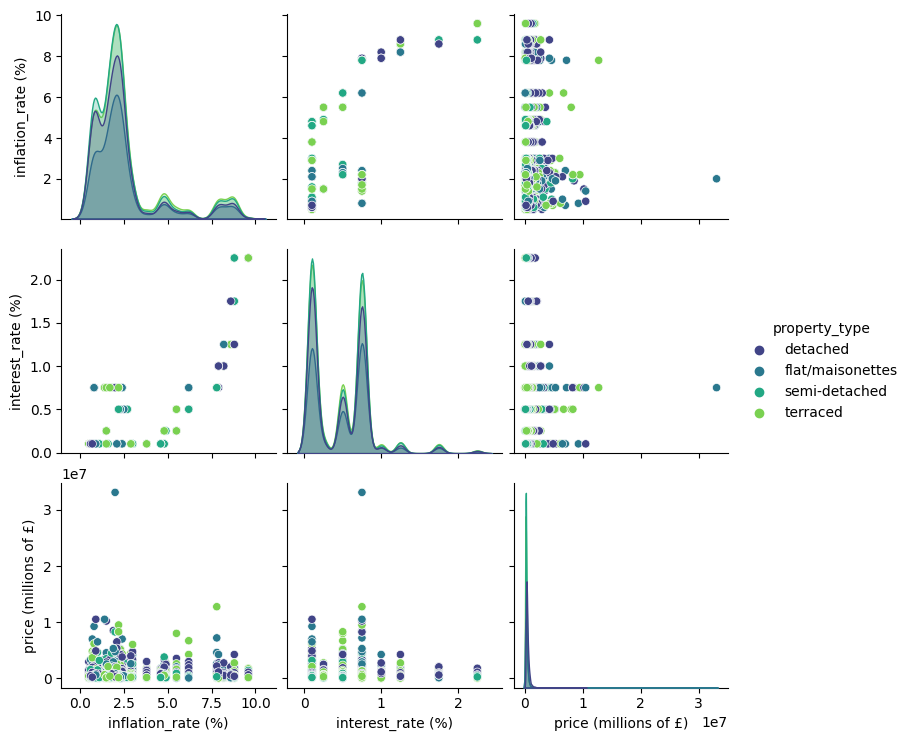

In [152]:
# plots the interaction between the continuous features
# with the `property_type` feature used for colouring the points
# and no regression line and no correlation coefficient
plot_continuous_features_interaction(
    df_1nf=df,
    hue="property_type",
    reg=False,
    corr=False,
)


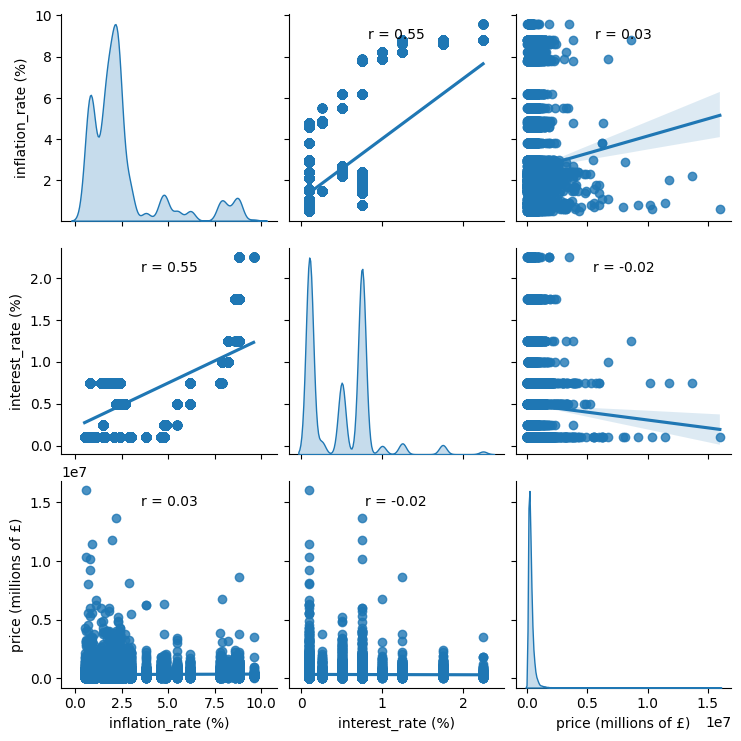

In [153]:
# plots the interaction between the continuous features
# without colouring the points
# and with a regression line and a correlation coefficient
plot_continuous_features_interaction(
    df_1nf=df,
    hue=None,
    reg=True,
    corr=True,
)


### Distribution of Inflation & Interest rates

Due to their high value, properties are often purchased with the help of credit.
And like any other product, they are subject to purchasing power of potential
buyers. These are fundamentally affected by Inflation & Interest Rates.

In this following section, we observe the distributions of rates for both,
as well as the 5%, 50% (median) and 95% percentiles, in order to determine
how often the most extreme rates appeared.


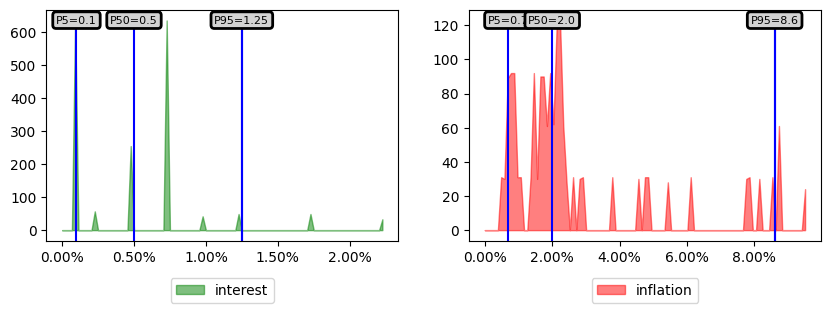

In [154]:
def plot_rate_distributions(
    ax,
    df: pd.DataFrame,
    label: str,
    color: str,
) -> None:
    """
    Plots the distribution of the `rate` feature as an area chart,
    indexed by the `label` feature, across 100 bins in the x axis.
    :param ax: the matplotlib axis to plot on
    :param df: the dataframe to plot
    :param label: the label of the plot
    :param color: the colour of the plot
    """
    # creates a copy of the dataframe to avoid modifying the original
    df = df.copy()
    # scales the `rate` feature
    df["rate"] = df["rate"] * 100.0
    # creates the bins for the x axis
    x = np.linspace(0.0, df["rate"].max(), 100)
    # segments the `rate` feature into bins
    df["bin"] = pd.cut(df["rate"], bins=x)
    # stores the number of points in each bin into `y`
    y = list(df.groupby("bin").count()["rate"])
    # plots the area chart with a formatter for the x axis
    ax.fill_between(x[:-1], 0.0, y, color=color, alpha=0.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    # defines the intervals that will be annotated on the plot
    intervals = [0.05, 0.5, 0.95]
    # annotates the plot with the quantiles of the `rate` feature
    for interval, quantile in zip(intervals, df.rate.quantile(intervals)):
        # creates the annotation text
        percentile = f"P{int(interval*100.)}={round(quantile, 2)}"
        # creates the annotation box
        bbox = dict(boxstyle="round, pad=0.3", fc="lightgray", lw=2)
        # plots the vertical line and annotation
        ax.axvline(x=quantile, color="blue")
        ax.annotate(percentile, xy=(quantile, max(y)), bbox=bbox, ha="center", va="center", fontsize=8)
    # plots the legend
    ax.axvline(x=quantile, color="blue")
    ax.legend([label], loc="lower center", bbox_to_anchor=(0.5, -0.3))


# groups the "1NF dataframe" by year, month and day
df_daily_means = df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True)
# create new dataframes for the interest and inflation rates, with rate columns named simply "rate"
df_daily_means_interest = df_daily_means[["interest_rate"]].rename(columns={"interest_rate": "rate"})
df_daily_means_inflation = df_daily_means[["inflation_rate"]].rename(columns={"inflation_rate": "rate"})
# creates the subplots for the interest and inflation rates
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
# plots the interest
plot_rate_distributions(
    ax=axes[0],
    df=df_daily_means_interest,
    label="interest",
    color="green",
)
# plots the inflation
plot_rate_distributions(
    ax=axes[1],
    df=df_daily_means_inflation,
    label="inflation",
    color="red",
)


### Price, Interest & Inflation in the Time-domain

The following section plots how the **Interest Rate**, the **Inflation Rate**
and the **Price** evolve over time. With that approach, if these variables are
strongly connected, it should be possible to observe they influencing one another.


100%|██████████| 4/4 [00:00<00:00, 69.88it/s]


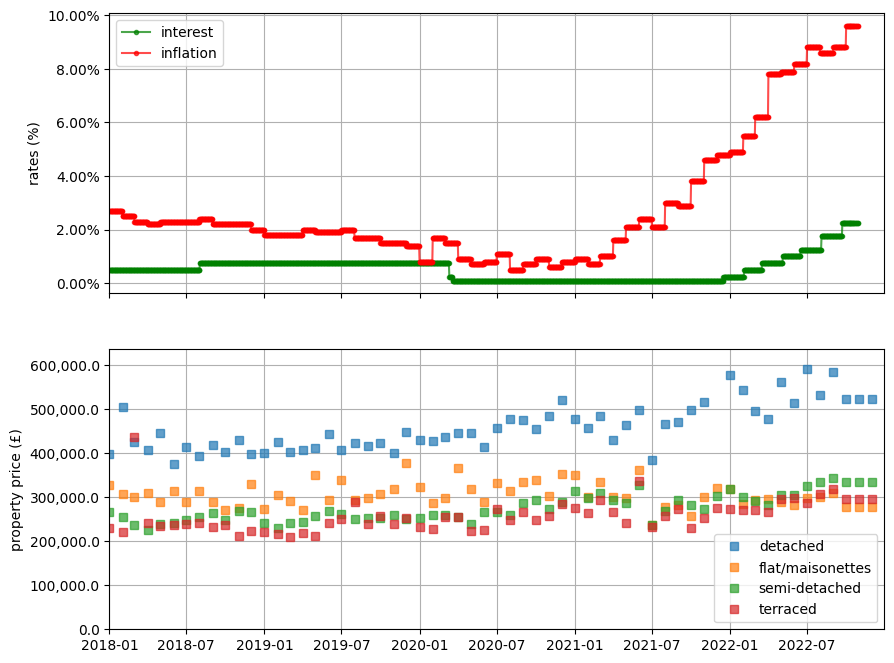

In [155]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date


def plot_inflation_and_interest(
    ax: plt.Axes,
    df_mean_by_date: pd.DataFrame,
    xlim_left: float,
    xlim_right: float,
) -> None:
    """
    Plots the inflation and interest rates as a line chart.
    :param ax: the matplotlib axis to plot on
    :param df_mean_by_date: the 1NF dataframe grouped by date
    :param xlim_left: the left limit of the x axis
    :param xlim_right: the right limit of the x axis
    :return: None
    """
    # resets the index of the dataframe, so the "date" columns become columns
    df_mean_by_date = df_mean_by_date.reset_index()
    # creates the x axis by combining year/month/day into a single date component
    x = df_mean_by_date.apply(lambda r: date(int(r.date_year), int(r.date_month), int(r.date_day)), axis=1)
    # turns on the grid for the plot
    ax.grid(visible=True)
    # plots the interest and inflation rates, with 70% transparency
    ax.plot(x, df_mean_by_date.interest_rate * 100.0, "g.-", alpha=0.7)
    ax.plot(x, df_mean_by_date.inflation_rate * 100.0, "r.-", alpha=0.7)
    # sets the x axis limits
    ax.set_xlim(left=xlim_left, right=xlim_right)
    # sets the y axis label to "rate (%)" with a formatter for the y axis
    ax.set_ylabel("rates (%)")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    # plots the legend
    ax.legend(["interest", "inflation"])


def plot_prices_and_rates_over_time_domain(
    ax: plt.Axes,
    df_mean_by_date_and_pt: pd.DataFrame,
) -> None:
    """
    Plots the property prices and interest/inflation rates over time.
    :param ax: the matplotlib axis to plot on
    :param df_mean_by_date_and_pt: the 1NF dataframe grouped by date and property type
    :return: None
    """
    # resets the index of the dataframe, so the "date" columns become columns
    df_mean_by_date_and_pt = df_mean_by_date_and_pt.reset_index()
    # turns on the grid for the plot
    ax.grid(visible=True)
    # formats the axis with a thousands separator and no decimal point
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,}"))
    # sets the y axis limits to 120% of the 95th percentile of the property prices
    # this will hide the 5% of the most expensive properties/outliers
    ax.set_ylim(0.0, df_mean_by_date_and_pt.price.quantile(0.95) * 1.2)
    # sets the y axis label to "property price (£)"
    ax.set_ylabel("property price (£)")
    # holds the property types
    property_types = sorted(df_mean_by_date_and_pt.property_type.unique())
    # plots the property prices as separate coloured markers
    for ix, property_type in tqdm(list(enumerate(property_types))):
        # creates a sub-series for the current property type
        sub_series = df_mean_by_date_and_pt[df_mean_by_date_and_pt.property_type == property_type].copy()
        # groups property values by year and month, and takes the mean
        sub_series = sub_series.reset_index().groupby(["date_year", "date_month"]).mean(numeric_only=True).reset_index()
        # fills in the missing values with the previous value
        sub_series = sub_series.fillna(method="ffill")
        # creates the x axis by combining year/month into a single date component
        x = sub_series.apply(lambda r: date(int(r.date_year), int(r.date_month), 1), axis=1)
        # plots the property prices as a scatter, with square markers, with 70% transparency
        ax.plot(x, sub_series.price, "s", alpha=0.7)
        # plots the legend
        ax.legend(property_types)


# holds the min and max intersecting dates, so we only show charts where data is available
min_intersecting_date = date(df.date_year.min(), 1, 1)
max_intersecting_date = date(df.date_year.max(), 12, 30)
# creates a figure with 2 subplots, sharing the x axis
_, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
# plots the inflation and interest rates
plot_inflation_and_interest(
    ax=axes[0],
    df_mean_by_date=df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True),
    xlim_left=min_intersecting_date,
    xlim_right=max_intersecting_date,
)
# plots the property prices and interest/inflation rates
plot_prices_and_rates_over_time_domain(
    ax=axes[1],
    df_mean_by_date_and_pt=df.groupby(["date_year", "date_month", "date_day", "property_type"]).mean(numeric_only=True),
)


### Proportion of Transactions per Property Type (Flat, Semi/Detatched, Terraced), Property State (Old/New), Contract Duration (Lease or Freehold)

As previously observed, the `property_type` is a major defining feature in
regards to the property price.

The following section plots the proportion of the dataset in regards to each one
of the categorical features present: `property_type`, `old_or_new`, `duration`,
although we do not plot the proportion per `postgroup`, because of the large
number of categories it presents.

In [160]:
def plot_proportion_of_transactions_per_feature(
    df_1nf: pd.DataFrame,
    title: str,
    index_name: str,
) -> None:
    """
    Plots the proportion pie-chart of transactions per feature.
    :param df_1nf: the 1NF dataframe
    :param title: the title of the plot
    :param index_name: the name of the index to group by
    :return: None
    """
    # groups the dataframe by the index name, and counts the number of transactions
    df_prop_count_per_type = df_1nf.reset_index().groupby([index_name])[["index"]].count()
    df_prop_count_per_type = df_prop_count_per_type.rename(columns={"index": "transactions"})
    # groups the dataframe by the index name, and sums the price
    df_prop_price_sum_per_type = df_1nf.groupby([index_name])[["price"]].sum()
    df_prop_price_sum_per_type = df_prop_price_sum_per_type.rename(columns={"price": "volume (£)"})
    # concatenates the two dataframes columns, and sorts by index
    df_prop = pd.concat([df_prop_count_per_type, df_prop_price_sum_per_type], axis=1).sort_index()

    # creates a figure with 2 subplots, one for the number of transactions, and one for the volume traded
    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
    axes[0].set_title("per number of transactions")
    axes[1].set_title("per volume traded (£)")

    # create the colour map and array of colours that will be used
    cm = plt.get_cmap("viridis")
    colors = [cm(1.0 * i / len(df_prop.index)) for i in range(len(df_prop.index))]
    # plot the pie chart showing the proportion of transactions per feature
    axes[0].pie(
        df_prop["transactions"],
        colors=colors,
        labeldistance=0.7,
        explode=0.2 * df_prop["transactions"] / df_prop["transactions"].sum(),
        shadow=True,
        autopct=lambda pct: f"{round(pct, 2)}%",
        pctdistance=0.7,
        textprops=dict(color="w"),
    )
    # plot the pie chart showing the proportion of volume traded per feature
    axes[1].pie(
        df_prop["volume (£)"],
        colors=colors,
        explode=0.2 * df_prop["volume (£)"] / df_prop["volume (£)"].sum(),
        shadow=True,
        autopct=lambda pct: f"{round(pct, 2)}%",
        pctdistance=0.7,
        textprops=dict(color="w"),
    )
    # sets the figure title
    fig.suptitle(title)
    # configures the figure as tight
    fig.tight_layout()
    # adds the legend to the figure
    fig.legend(df_prop.index, loc="lower center", bbox_to_anchor=(0.5, 0), ncols=len(df_prop_count_per_type.index))


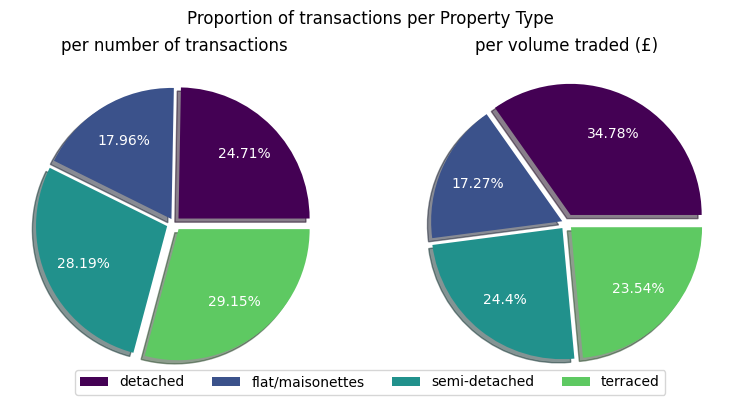

In [161]:
# plots the proportion of transactions per property type (transactions & volume £)
plot_proportion_of_transactions_per_feature(
    df_1nf=df,
    title="Proportion of transactions per Property Type",
    index_name="property_type",
)


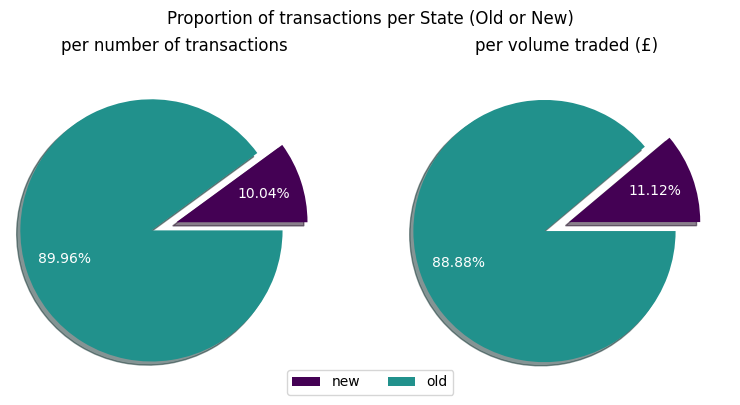

In [162]:
# plots the proportion of transactions per old/new state (transactions & volume £)
plot_proportion_of_transactions_per_feature(
    df_1nf=df,
    title="Proportion of transactions per State (Old or New)",
    index_name="old_or_new",
)


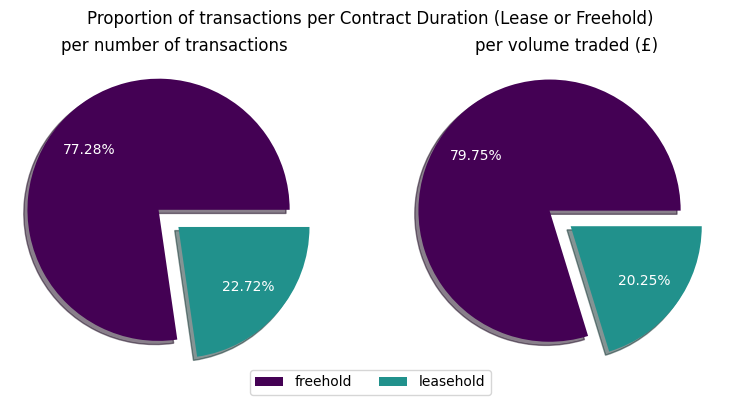

In [163]:
# plots the proportion of transactions per contract duration (transactions & volume £)
plot_proportion_of_transactions_per_feature(
    df_1nf=df,
    title="Proportion of transactions per Contract Duration (Lease or Freehold)",
    index_name="duration",
)


## Machine learning model


In [22]:
from datetime import datetime

r = 42
train_size = 0.99
experiment_name = f"exp-20221228_1755"
(experiment_name, r, train_size)


('exp-20221228_1755', 42, 0.99)

In [23]:
import pathlib

results_dir = pathlib.Path(f"./results/{experiment_name}")
results_dir.mkdir(parents=True, exist_ok=True)
results_dir


PosixPath('results/exp-20221228_1755')

In [24]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
423820,2018,6,28,3,TR1,terraced,new,freehold,0.023,0.005,"194,250.000"
2116762,2020,4,9,3,L25,terraced,old,freehold,0.009,0.001,"145,000.000"
2648185,2020,12,8,1,RM16,semi-detached,old,freehold,0.008,0.001,"405,000.000"
1069775,2019,2,20,2,SK5,semi-detached,old,freehold,0.018,0.007,"149,950.000"
2666509,2020,12,11,4,BB12,semi-detached,old,freehold,0.008,0.001,"172,000.000"


### Feature Matrix & Targets


In [25]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]
del df


### Hold-out Test-Sets


In [26]:
from typing import Tuple
from sklearn.model_selection import train_test_split


def produce_split_summary(
    X_split: pd.DataFrame, y_split: pd.DataFrame, name: str, total: int
) -> Tuple[str, int, int, str]:
    return (
        name,
        X_split.shape[0],
        y_split.shape[0],
        "{:.1f}%".format(100.0 * X_split.shape[0] / total),
    )


X1, X2, y1, y2 = train_test_split(X, y, train_size=train_size, random_state=r)
print(
    pd.DataFrame(
        [
            produce_split_summary(X, y, "full", total=X1.shape[0]),
            produce_split_summary(X1, y1, "train", total=X.shape[0]),
            produce_split_summary(X2, y2, "test", total=X.shape[0]),
        ],
        columns=["split", "|X|", "|y|", "%"],
    )
)
del X, y


   split      |X|      |y|       %
0   full  4336841  4336841  101.0%
1  train  4293472  4293472   99.0%
2   test    43369    43369    1.0%


### Model Pipeline


In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [28]:
from typing import Tuple
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def make_sine_cycle_encoder(period: int = 1) -> float:
    assert period != 0
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


# https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use
def make_df_column_transformer(scale_non_categorical: bool = False):
    categorical_selector = make_column_selector(dtype_include="category")
    non_categorical_selector = make_column_selector(dtype_exclude="category")
    one_hot = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    cycle_sine_12 = make_sine_cycle_encoder(period=12)
    cycle_sine_31 = make_sine_cycle_encoder(period=31)
    cycle_sine_6 = make_sine_cycle_encoder(period=6)
    steps = [
        (one_hot, categorical_selector),
        (cycle_sine_12, ["date_month"]),
        (cycle_sine_31, ["date_day"]),
        (cycle_sine_6, ["date_day_of_week"]),
    ]
    if scale_non_categorical:
        scaler = StandardScaler(with_mean=True, with_std=True)
        steps.append((scaler, non_categorical_selector))
    return make_column_transformer(*steps, remainder="passthrough")


def make_svd_polynomial_regression_model(
    random_state: int,
    svd_dims: int = 1,
    polynomial_degree: int = 1,
    fit_intercept: bool = False,
    verbose: bool = False,
):
    return make_pipeline(
        make_df_column_transformer(),
        TruncatedSVD(n_components=svd_dims, algorithm="arpack", random_state=r),
        PolynomialFeatures(degree=polynomial_degree, include_bias=False),
        LinearRegression(fit_intercept=fit_intercept),
        verbose=verbose,
    )


def make_mlp_regression_model(
    random_state: int,
    embedding_layer_dims: int = None,
    residual_layer_dims: int = 1,
    verbose: bool = False,
):
    hidden_layer_sizes = []
    if embedding_layer_dims:
        hidden_layer_sizes.append(embedding_layer_dims)
    if residual_layer_dims:
        hidden_layer_sizes.append(residual_layer_dims)
    return make_pipeline(
        make_df_column_transformer(scale_non_categorical=True),
        MLPRegressor(
            hidden_layer_sizes=tuple(hidden_layer_sizes),
            solver="adam",
            alpha=0.0001,
            max_iter=1,
            early_stopping=True,
            random_state=random_state,
            verbose=verbose,
        ),
        verbose=verbose,
    )


models = {
    "svd_polynomial_regression": make_svd_polynomial_regression_model(random_state=r, verbose=True),
    "mlp_regression": make_mlp_regression_model(random_state=r, verbose=True),
}
for model_name, model_instance in models.items():
    print(f"[{model_name}]")
    model_instance.fit(X1, y1)
    y1_pred = model_instance.predict(X1)
    y2_pred = model_instance.predict(X2)
    model_metrics = {
        "train": {
            "mae": mean_absolute_error(y1_pred, y1),
            "mape": mean_absolute_percentage_error(y1_pred, y1),
            "r2": mean_absolute_error(y1_pred, y1),
        },
        "test": {
            "mae": mean_absolute_error(y2_pred, y2),
            "mape": mean_absolute_percentage_error(y2_pred, y2),
            "r2": mean_absolute_error(y2_pred, y2),
        },
    }
    print(pd.DataFrame.from_dict(model_metrics))
del models
del model_metrics
del y1_pred, y2_pred


[svd_polynomial_regression]
[Pipeline] . (step 1 of 4) Processing columntransformer, total=  13.7s
[Pipeline] ...... (step 2 of 4) Processing truncatedsvd, total=   4.5s
[Pipeline]  (step 3 of 4) Processing polynomialfeatures, total=   0.0s
[Pipeline] .. (step 4 of 4) Processing linearregression, total=   0.3s
           train        test
mae  173,341.905 174,260.022
mape       0.545       0.548
r2   173,341.905 174,260.022
[mlp_regression]
[Pipeline] . (step 1 of 2) Processing columntransformer, total=  13.1s
Iteration 1, loss = 131560605211.27497864
Validation score: -0.741920
[Pipeline] ...... (step 2 of 2) Processing mlpregressor, total=  18.3s
           train        test
mae  318,083.011 318,492.447
mape  16,794.989  16,816.608
r2   318,083.011 318,492.447


### GridSearch with Cross-Validation


In [29]:
import json
import numpy as np
from datetime import datetime
from typing import List, Dict, Tuple, Any
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def make_grid(
    model: Pipeline,
    param_grid: Dict[str, Any],
) -> GridSearchCV:
    return GridSearchCV(
        model,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_absolute_percentage_error",
        verbose=3,
    )


def compile_best_metrics(
    grid: GridSearchCV,
    training_data: Tuple[np.array, np.array],
    test_data: Tuple[np.array, np.array],
) -> pd.DataFrame:
    X_train, y_true_train = training_data
    X_test, y_true_test = test_data
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)
    return pd.DataFrame.from_dict(
        {
            "train": {
                "mae": mean_absolute_error(y_pred_train, y_true_train),
                "mape": mean_absolute_percentage_error(y_pred_train, y_true_train),
                "r2": r2_score(y_pred_train, y_true_train),
            },
            "test": {
                "mae": mean_absolute_error(y_pred_test, y_true_test),
                "mape": mean_absolute_percentage_error(y_pred_test, y_true_test),
                "r2": r2_score(y_pred_test, y_true_test),
            },
        }
    )


def compile_search_data(cv_results: Dict[str, Any]):
    df_search = pd.DataFrame.from_dict(cv_results)
    df_search = df_search.sort_values(by="rank_test_score").reset_index(drop=True)
    df_search_cols_key = ["rank_test_score"]
    df_search_cols_key.extend([c for c in df_search.columns.tolist() if c.startswith("param_")])
    df_search_cols_key.extend(["mean_test_score", "std_test_score"])
    df_results_cols_rest = [c for c in df_search.columns.tolist() if c not in df_search_cols_key]
    df_results_cols_rest.remove("params")
    return df_search[df_search_cols_key + df_results_cols_rest]


def export_grid_results(results_dir: pathlib.Path, experiment_name: str, results: List[Tuple[str, pd.DataFrame]]):
    experiment_dir = results_dir / experiment_name
    experiment_dir.mkdir(parents=True, exist_ok=True)
    for result_name, result_df in results:
        result_df.to_csv(experiment_dir / f"{result_name}.csv")


def run_grid_experiment(
    experiment: str,
    model: Pipeline,
    training_data: Tuple[np.array, np.array],
    test_data: Tuple[np.array, np.array],
    param_grid: Dict[str, Any],
    results_dir: pathlib.Path,
):
    print(f"[{experiment}]")
    grid = make_grid(model, param_grid)
    X_train, y_train = training_data
    grid.fit(X_train, y_train)
    df_best_params = pd.DataFrame.from_dict(grid.best_params_, orient="index")
    df_best_metrics = compile_best_metrics(grid, training_data, test_data)
    df_search_data = compile_search_data(grid.cv_results_)
    export_grid_results(
        results_dir=results_dir,
        experiment_name=experiment,
        results=[
            ("best-params", df_best_params),
            ("best-metrics", df_best_metrics),
            ("search-data", df_search_data),
        ],
    )
    return df_best_metrics


### Grid Search: Polynomial Linear Regression


In [30]:
model = make_svd_polynomial_regression_model(random_state=r)


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_canary",
    model=model,
    training_data=(X1[0:5000], y1[0:5000]),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [1],
        "polynomialfeatures__degree": [1],
        "linearregression__fit_intercept": [False],
    },
    results_dir=results_dir,
)


/var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/ipykernel_22899/1565712382.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  training_data=(X1[0:5000], y1[0:5000]),


[svd_polynomial_regression_canary]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.836 total time=   0.1s
[CV 2/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.892 total time=   0.0s
[CV 3/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.837 total time=   0.1s
[CV 4/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.803 total time=   0.1s
[CV 5/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.799 total time=   0.1s


,train,test
mae,"173,160.978","174,395.551"
mape,0.544,0.547
r2,"-5,048,658.856","-4,409,838.730"


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_sm",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [3],
        "polynomialfeatures__degree": [1, 2, 3],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_sm]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.196 total time=  10.7s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.551 total time=  11.9s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-2.336 total time=  10.8s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-0.827 total time=  11.4s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.552 total time=  11.7s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=2, truncatedsvd__n_components=3;, score=-1.195 total time=  15.5s
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"171,718.854","172,698.039"
mape,0.540,0.543
r2,-169.194,-212.548


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_md",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [4, 5, 6],
        "polynomialfeatures__degree": [3],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_md]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.102 total time=  34.9s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.471 total time=  30.9s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-2.340 total time=  26.1s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-0.802 total time=  22.8s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.324 total time=  23.3s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=5;, score=-1.127 total time=  38.8s
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"159,951.421","161,246.722"
mape,0.509,0.514
r2,-19.009,-24.136


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_lg",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [4, 5],
        "polynomialfeatures__degree": [4],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_lg]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.088 total time=  55.4s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.449 total time=  50.3s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-2.323 total time=  50.7s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-0.801 total time=  48.4s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.317 total time=  46.6s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=5;, score=-1.105 total time= 3.1min
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"169,389.066","170,279.231"
mape,0.532,0.535
r2,-71.545,-89.154


### Grid Searrch: MLP Regression


In [31]:
model = make_mlp_regression_model(random_state=r)


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_emb_only",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(2,), (4,), (8,)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_emb_only]
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.040 total time= 4.0min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.505 total time= 6.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.000 total time= 3.3min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.692 total time= 3.9min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.286 total time= 3.8min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,

,train,test
mae,"154,364.527","155,374.364"
mape,0.478,0.481
r2,-39.092,-49.907


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_sm",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(2, 2), (2, 4)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_sm]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.684 total time= 5.4min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.637 total time= 7.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.893 total time= 6.9min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.308 total time= 4.4min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.792 total time= 4.4min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"99,549.909","100,044.293"
mape,0.328,0.327
r2,-1.541,-2.472


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_md",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(4, 4), (4, 8)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_sm]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.733 total time= 9.7min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.690 total time= 9.6min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.962 total time=11.1min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.347 total time= 9.3min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.761 total time= 9.8min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"89,541.390","90,766.460"
mape,0.260,0.262
r2,-0.590,-1.255


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_lg",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(8, 8), (8, 16)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_lg]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.598 total time=10.3min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.649 total time=11.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.676 total time=15.3min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.298 total time=10.2min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.744 total time=10.2min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"89,136.722","90,317.630"
mape,0.261,0.262
r2,-0.480,-1.075


### Combining Grid Search Results


# III. Conclusions


## Performance of results


## Closing remarks/statements


# IV. References

<a id="ref:2007:hjort-et-al"></a>
[1] Anders Hjort, Johan Pensar, Ida Scheel & Dag Einar Sommervoll (2022) 'House price prediction with gradient boosted trees under different loss functions', Journal of Property Research, 39:4, 338-364, DOI: 10.1080/09599916.2022.2070525. Source: https://www.tandfonline.com/doi/pdf/10.1080/09599916.2022.2070525

<a id="ref:2022:rastegar"></a>
[2] Rastegar, Kellie. 'Why Large Pension Funds Are Investing In Private Real Estate', Forbes, 2022. Source: https://www.forbes.com/sites/forbesbusinesscouncil/2022/02/14/why-large-pension-funds-are-investing-in-private-real-estate/?sh=2d5cd1a11e45

<a id="ref:web:rightmove-avm"></a>
[3] AVM, Automated Valuation Model Service by RightMove. Source: https://www.rightmove.co.uk/property-data/automated-valuation-model/

<a id="ref:2021:xu-et-al"></a>
[4] Xu, Xiaojie, and Yun Zhang. ‘House Price Forecasting with Neural Networks’. Intelligent Systems with Applications, vol. 12, 2021, p. 200052, https://doi.org10.1016/j.iswa.2021.200052.
Source: https://reader.elsevier.com/reader/sd/pii/S2667305321000417?token=3FC43BE0FD2A4CFD9181E501BDEAE82235A2E12119F2570BEA114D70B8C1B622FB91CB03A10C5EDB66134567FF2D49AD&originRegion=eu-west-1&originCreation=20230102163119

<a id="ref:web:uk-land-registry"></a>
[5] "Price Paid Data", Last updated
30 December 2022, HM Land Registry. Source: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

<a id="ref:web:uk-boe-interest"></a>
[6] "Official Bank Rate history". Bank of England, 2022. Source: https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp

<a id="ref:web:uk-ons-cpih"></a>
[7] "CPIH ANNUAL RATE 00: ALL ITEMS 2015=100", Office for National Statistics, 2022. Source: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23

<a id="ref:2022:shaun"></a>
[8] Turney Shaun, "Pearson Correlation Coefficient (r) | Guide & Examples", Scribbr, 2022. Source: https://www.scribbr.com/statistics/pearson-correlation-coefficient
